# Import dataset

In [1]:
import pandas as pd
import json
import numpy as np 
import matplotlib.pyplot as plt
from transformers import set_seed 
import nlpaug.augmenter.word as naw 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report 
from skmultilearn.problem_transform import BinaryRelevance 
from sklearn.feature_extraction.text import CountVectorizer 

pd.set_option('display.max_colwidth', 200)

## Load data from json file

In [3]:
df_issues = pd.read_json("dataset.json", lines=True)

In [4]:
df_issues.shape

(9930, 26)

In [5]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()


,2
url,https://api.github.com/repos/huggingface/transformers/issues/11044
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting started and issues
user,"{'login': 'stas00', 'id': 10676103, 'node_id': 'MDQ6VXNlcjEwNjc2MTAz', 'avatar_url': 'https://avatars.githubusercontent.com/u/10676103?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNjU5MjY3MDI1', 'url': 'https://api.github.com/repos/huggingface/transformers/labels/DeepSpeed', 'name': 'DeepSpeed', 'color': '4D34F7', 'default': False..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the release, so please ignore for now]**\r\n\r\nThe DeepSpeed ZeRO-3 has been integrated into HF `transformers`. \r\n\r\nWhile I tried to write tests for a ..."


In [6]:
# print all the columns
print(df_issues.columns)

Index(['url', 'repository_url', 'labels_url', 'comments_url', 'events_url',
       'html_url', 'id', 'node_id', 'number', 'title', 'user', 'labels',
       'state', 'locked', 'assignee', 'assignees', 'milestone', 'comments',
       'created_at', 'updated_at', 'closed_at', 'author_association',
       'active_lock_reason', 'body', 'performed_via_github_app',
       'pull_request'],
      dtype='object')


## Process label

In [7]:
df_issues["labels"] = (df_issues["labels"]
 .apply(lambda x: [meta["name"] for meta in x]))
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [8]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}") 
df_counts.head(10).to_frame().T

Number of labels: 65


labels,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage,Core: Pipeline,Feature request
count,2284,649,106,98,64,52,50,46,42,41


In [9]:
label_map = {"Core: Tokenization": "tokenization",
 "New model": "new model",
 "Core: Modeling": "model training",
 "Usage": "usage",
 "Core: Pipeline": "pipeline",
 "TensorFlow": "tensorflow or tf",
 "PyTorch": "pytorch",
 "Examples": "examples",
 "Documentation": "documentation"}

In [10]:
def filter_lables(x): 
    return [label_map[label] for label in x if label in label_map] 
df_issues["labels"] = df_issues["labels"].apply(filter_lables) 
all_labels = list(label_map.values()) 

In [11]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}")
df_counts.head(10).to_frame().T

Number of labels: 9


labels,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
count,106,98,64,46,42,41,37,28,24


## save the unlabels data

In [12]:
df_issues["split"] = "unlabeled"
mark = df_issues["labels"].apply(lambda x: len(x) > 0)
df_issues.loc[mark, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,count
split,
unlabeled,9489
labeled,441


In [13]:
# print some examples
for colume in ['title', 'body', 'labels']:
    print(f"{colume}: {df_issues[colume].iloc[26][:500]}\n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels: ['new model']



In [14]:
# concat the title and body 
df_issues['text'] = (df_issues
                     .apply(lambda x: f"{x['title']} +  {x['body']}", axis=1))

In [15]:
df_issues['text'].head()

0    Potential incorrect application of layer norm in BlenderbotSmallDecoder +  In BlenderbotSmallDecoder,  layer norm is applied only on the token embeddings, and not on the hidden_states, whereas in ...
1    Multi-GPU seq2seq example evaluation significantly slower than legacy example evaluation +  \r\n### Who can help\r\n@patil-suraj @sgugger \r\n\r\nModels:\r\nT5\r\n\r\n## Information\r\n\r\nI've be...
2    [DeepSpeed] ZeRO stage 3 integration: getting started and issues +  **[This is not yet alive, preparing for the release, so please ignore for now]**\r\n\r\nThe DeepSpeed ZeRO-3 has been integrated...
3    Can't load model to estimater +  I was trying to follow the Sagemaker instructions [here](https://docs.aws.amazon.com/sagemaker/latest/dg/deploy-model.html) to load the model I just trained and te...
4    [LXMERT] Unclear what img_tensorize does with color spaces +  ## Environment info\r\n\r\n- `transformers` version: Not using transformers directly, I'm loading a model "unc-nl

In [16]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset=['text'])
print(f"Remove {(len_before - len(df_issues)) / len_before:.2%} duplicates.")


Remove 1.88% duplicates.


# Creating training set

In [17]:
#create balance split by using sk ml
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"], ["pytorch"]])  # example of target encoding

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

## split dataset

In [18]:
from skmultilearn.model_selection import iterative_train_test_split 
def balanced_split(df , test_size = 0.5): 
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"]) # transform labels to binary
    ind_train , _ , ind_test, _  = iterative_train_test_split(ind, labels, test_size=test_size) # split data
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:, 0]]  # return train and test DataFrames

In [19]:
from sklearn.model_selection import train_test_split
df_clean = df_issues[["text" , "labels", "split"]].reset_index(drop=True).copy() 
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]].copy()
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]].copy()

np.random.seed(0)
 
df_train , df_tmp = balanced_split(df_sup, test_size=0.5) 
df_valid , df_test = balanced_split(df_tmp, test_size=0.5) 

## Create datasetDict

In [20]:
from datasets import Dataset, DatasetDict 
ds = DatasetDict({"train": Dataset.from_pandas(df_train.reset_index(drop=True)),
                  "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
                    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
                    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))
                  })

## Creating Training slices

In [21]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))) , axis=1) 
print(f"Number of samples: {len(all_indices)}")
indices_pool = all_indices 
lables = mlb.transform(ds["train"]["labels"]) 
train_samples =  [8, 16, 32, 64, 128] 
train_slices , last_k = [], 0 
for i , k in enumerate(train_samples):
    # split off samples necessary to fill the gap to the next split size
    indices_pool, lables, new_slice, _ = iterative_train_test_split(indices_pool, lables, (k - last_k)/len(lables))
    last_k = k 
    if i == 0:
        train_slices.append(new_slice)
    else: train_slices.append(np.concatenate([train_slices[-1], new_slice]))
# add full dataset as last slice 
train_slices.append(all_indices) , train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(x) for x in train_slices]

Number of samples: 223


In [22]:
def prepare_labels(batch): 
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch
ds = ds.map(prepare_labels, batched=True) 

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [23]:
df_train.head()

,text,labels
26,Add new CANINE model + # 🌟 New model addition\r\n\r\n## Model description\r\n\r\nGoogle recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncod...,[new model]
107,Please implement DUMA: Reading Comprehension with Transposition Thinking + # 🚀 Feature request\r\n\r\n<!-- A clear and concise description of the feature proposal.\r\n Please provide a link t...,[new model]
264,Can DeepSpeed ZeRO-3 be applied for training? + # 🌟 New model addition\r\n\r\nWe have applied DeepSpeed v0.3.10(ZeRO-2) on T5 training. \r\nI heard DeepSpeed ZeRO-3 library has been released 10 ...,[new model]
484,XLSR-53 + # 🚀 Feature request\r\n\r\nIs it possible to use XLSR-53 with transformers in the near future? \r\n,[new model]
566,[examples] should all examples support the predict stage? + This is part of the ongoing effort to sync the example scripts.\r\n\r\nIn https://github.com/huggingface/transformers/issues/10437#issu...,[examples]


In [24]:
def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    for run in micro_scores.keys():
        if run == current_model:
            print(run)
            ax0.plot(sample_sizes, micro_scores[run], label = run , linewidth=2)            
            ax1.plot(sample_sizes, macro_scores[run], label = run , linewidth=2)
        else:
            print(run)
            ax0.plot(sample_sizes, micro_scores[run], label=run,linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run,linestyle="dashed")
    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

In [25]:
import torch
device  = "cuda" if torch.cuda.is_available() else "cpu"

In [26]:
import os
hf_auth  = os.getenv("HF_AUTH_TOKEN")

# Embeddings_as_a_lookup_table.ipynb

## Use lamma model

In [27]:
# import torch 
# from torch import cuda, bfloat16
# from transformers import AutoTokenizer, AutoModel 
# import transformers
# model_id = "meta-llama/Llama-2-7b-hf"
# model_config = transformers.AutoConfig.from_pretrained(
#     model_id,
#     use_auth_token=hf_auth
# )
# # load model in 4bit quantization mode
# bnb_config = transformers.BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type='nf4',
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_compute_dtype=bfloat16
# )
# # load model with hf credentials
# model = transformers.AutoModelForCausalLM.from_pretrained(
#     model_id,
#     trust_remote_code=True,
#     config=model_config,
#     quantization_config=bnb_config,
#     device_map='auto',
#     use_auth_token=hf_auth,
# )
# tokenizer = AutoTokenizer.from_pretrained(model_id, use_auth_token=hf_auth)
# def mean_pooling(model_output, anttention_mask): 
#     """ mean pooling of the token embeddings, ignoring the masked tokens
#     """
#     # Extract the token embedding 
#     token_embeddings = model_output[0] # First element of model_output contains all token embeddings 
#     # compute attention mask 
#     input_mask_expanded = (anttention_mask
#                            .unsqueeze(-1)
#                            .expand(token_embeddings.size())
#                            .float()) 
#     # Sum the embeddings , but ignore masked tokens
#     sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1) 
#     sum_mark = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
#     # Return the average as a single vector
#     return sum_embeddings / sum_mark

# def embed_text(examples):
#     """embedding text using the model"""
#     inputs = tokenizer(examples["text"], padding=True, truncation=True, 
#                        max_length=128, return_tensors="pt",).to(device)
#     with torch.no_grad(): 
#         model_output = model(**inputs)
#     pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
#     return {"embedding": pooled_embeds.cpu().numpy()}

## Use GPT 2 model 


In [28]:
import torch
from transformers import AutoTokenizer, AutoModel
model_ckpt = "miguelvictor/python-gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt).to(device)
def mean_pooling(model_output, attention_mask):
    # Extract the token embeddings
    token_embeddings = model_output[0]
    # Compute the attention mask
    input_mask_expanded = (attention_mask
    .unsqueeze(-1)
    .expand(token_embeddings.size())
    .float())
    # Sum the embeddings, but ignore masked tokens
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    # Return the average as a single vector
    return sum_embeddings / sum_mask

In [29]:
def embed_text(examples):
    inputs = tokenizer(examples["text"], padding=True, truncation=True,
    max_length=128, return_tensors="pt").to(device)
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    # pooled_embeds = pooled_embeds.to(device)
    return {"embedding": pooled_embeds.cpu().numpy()}

tokenizer.eos_token

'<|endoftext|>'

In [30]:
tokenizer.pad_token = tokenizer.eos_token
embs_train = ds["train"].map(embed_text, batched=True, batch_size=128)
embs_valid = ds["valid"].map(embed_text, batched=True, batch_size=128)
embs_test = ds["test"].map(embed_text, batched=True, batch_size=128)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

## Use FAISS library to embedding

In [31]:
embs_train.add_faiss_index("embedding") # add faiss index

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['text', 'labels', 'label_ids', 'embedding'],
    num_rows: 223
})

## Use FAISS library to search

In [32]:
i , k = 2 , 3 # Select the first query and 3 nearest neighbors
rn , nl = "\r\n\r\n" , "\n" # Used to remove newlines in text for compact display  

query = np.array(embs_valid[i]["embedding"], dtype = np.float32) # query to search is embedding  
scores, samples = embs_train.get_nearest_examples("embedding", query, k=k)  # search from train data 

print(f"QUERY LABELS: {embs_valid[i]['labels']}") # print query labels (input)
print(f"QUERY TEXT:\n{embs_valid[i]['text'][:200].replace(rn, nl)} [...]\n") # print query text (input)
print("="*50)
print(f"Retrieved documents:") # print retrieved documents
for score, label, text in zip(scores, samples["labels"], samples["text"]):
    print("="*50)
    print(f"TEXT:\n{text[:200].replace(rn, nl)} [...]")
    print(f"SCORE: {score:.2f}")
    print(f"LABELS: {label}")
# all the text same label

QUERY LABELS: ['examples']
QUERY TEXT:
[example scripts] inconsistency around eval vs val +  * `val` == validation set (split)
* `eval` == evaluation (mode)
those two are orthogonal to each other - one is a split, another is a model's  [...]

Retrieved documents:
TEXT:
[readability] consolidate examples/summarization/bart  and examples/summarization/t5 +  This involves 
- [ ]  consolidating README.md 
- [ ]  consolidating evaluate_cnn.py scripts.
- [ ]  evaluat [...]
SCORE: 93.93
LABELS: ['examples']
TEXT:
TF: Faster to way to set one column/all but one column of a tensor to -inf +  in `_force_token_id_to_be_generated` we have much simpler torch code:
```python
scores[:, [x for if x != token_id]] = -f [...]
SCORE: 95.44
LABELS: ['tensorflow or tf']
TEXT:
[examples] should all examples support the predict stage? +  This is part of the ongoing effort to sync the example scripts.
In https://github.com/huggingface/transformers/issues/10437#issuecomment [...]
SCORE: 98.52
LABELS: ['examples

## Find the best value for k

In [33]:
def get_sample_pred(sample, m): 
    return (np.sum(sample["label_ids"], axis = 0) >= m ).astype(int) 
def find_best_k_m(ds_train, valid_queries, valid_labels, max_k = 17): 
    max_k = min(max_k, len(ds_train)) 
    perf_micro = np.zeros((max_k, max_k))
    perf_macro = np.zeros((max_k, max_k))
    for k in range(1, max_k): 
        for m in range(1 , k + 1 ):
            _ , samples = ds_train.get_nearest_examples_batch("embedding", valid_queries, k=k)
            preds = np.array([get_sample_pred(sample, m) for sample in samples])
            clf_report = classification_report(valid_labels, preds,
                                               target_names=mlb.classes_, zero_division=0, output_dict=True)
            perf_micro[k, m] = clf_report["micro avg"]["f1-score"]
            perf_macro[k, m] = clf_report["macro avg"]["f1-score"]
    return perf_micro, perf_macro 

/home/nghiaph/GEC/GEC_env/lib/python3.8/site-packages/matplotlib/text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


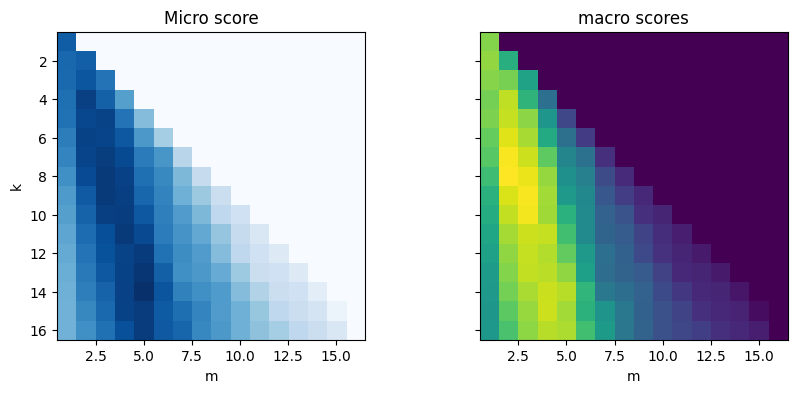

In [34]:
valid_labbels = np.array(embs_valid["label_ids"]) 
valid_queries = np.array(embs_valid["embedding"], dtype = np.float32) 
perf_micro, perf_macro = find_best_k_m(embs_train, valid_queries, valid_labbels)

fig , (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True) 
ax0.imshow(perf_micro, cmap="Blues")
ax1.imshow(perf_macro, cmap="Blues")

ax0.set_title(perf_micro)
ax1.imshow(perf_macro)

ax0.set_title("Micro score")
ax0.set_ylabel("k")
ax1.set_title("macro scores")
for ax in [ax0,ax1]:
    ax.set_xlim(0.5,17-0.5)
    ax.set_ylim(17-0.5,0.5)
    ax.set_xlabel("m")
plt.show()

In [35]:
k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape) # perf_micro shape = (k,m)
print(f"Best k: {k}, best m: {m}")

Best k: 14, best m: 5


## Plot the metrics

### init macro and micro

In [43]:
# import defaultdict
from collections import defaultdict
macro_scores = defaultdict(list,
            {'Naive Bayes': [0.23288166214995487,
              0.21006897585844955,
              0.24086240556828795,
              0.25730500818220114,
              0.28271105113210376,
              0.27403710305671086],
             'Zero-Shot': [0.3869340923536515,
              0.3869340923536515,
              0.3869340923536515,
              0.3869340923536515,
              0.3869340923536515,
              0.3869340923536515],
})

micro_scores = defaultdict(list,
            {'Naive Bayes': [0.3604651162790698,
              0.30208333333333337,
              0.41081081081081083,
              0.4435483870967742,
              0.5046728971962616,
              0.5346534653465347],
             'Zero-Shot': [0.4444444444444445,
              0.4444444444444445,
              0.4444444444444445,
              0.4444444444444445,
              0.4444444444444445,
              0.4444444444444445],
})


In [44]:
# make a copy of embs_train
embs_train_copy = embs_train.map(lambda x: x)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

In [45]:
# embs_train_copy.add_faiss_index("embedding")

### Plot the metrics

In [46]:
best_k_m = [(2,1), (7,2), (15,3), (3,2), (5,2), (14,5)]

In [47]:
macro_scores["Embedding"] = []
micro_scores["Embedding"] = []
# embs_train_copy.drop_index("embedding") # remove faiss index
test_labels = np.array(embs_test["label_ids"])
test_queries = np.array(embs_test["embedding"], dtype = np.float32) 

for train_slice in train_slices:
    # Craete a Faiss index from training slice
    embs_train_tmp = embs_train_copy.select(train_slice) 
    embs_train_tmp.add_faiss_index("embedding") 
    # get best k,m values with validation set 
    # k , m = find_best_k_m(embs_train_tmp, valid_queries, valid_labbels)
    # k , m = np.unravel_index(k.argmax(), k.shape)
    k , m = best_k_m.pop(0)
    # Get predictions for test set
    _ , samples = embs_train_tmp.get_nearest_examples_batch("embedding", test_queries, k=int(k)) 
    preds = np.array([get_sample_pred(sample, m) for sample in samples]) 
    # Evaluate predictions
    clf_report = classification_report(test_labels, preds, target_names=mlb.classes_, zero_division=0, output_dict=True) 
    macro_scores["Embedding"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Embedding"].append(clf_report["micro avg"]["f1-score"])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Naive Bayes
Zero-Shot
Embedding


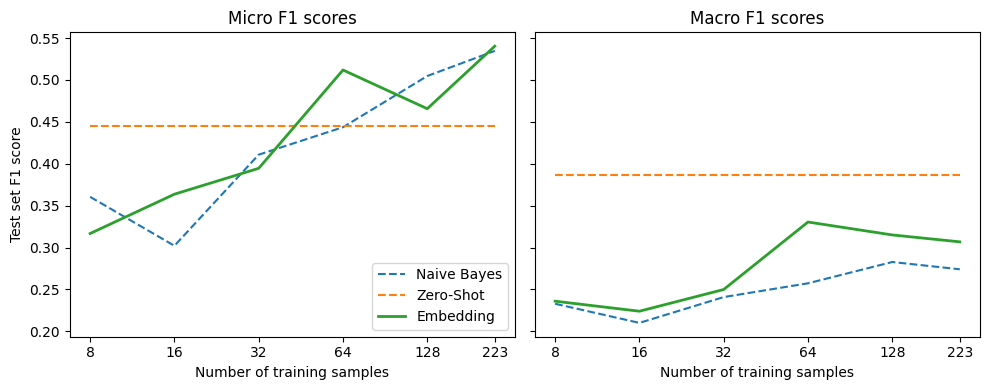

In [49]:
plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")